# Thermal stability of hundreds of point mutants of a family 1 glycoside hydrolase 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
from scipy.optimize import curve_fit 
from numpy import log, exp, linspace, sqrt, diag
from sklearn.linear_model import LinearRegression
import os
import re 

df = pandas.read_csv( 'data/Bagel Thermostability - Thermostability assay data.csv' )
raw = len( df )
df.index = df.mutant
df.drop( 'mutant', inplace=True )
df.drop( ['WT', 'WT1'], inplace=True )
df.dropna( inplace=True ) 

with open( 'data/allowed_mutants.txt' ) as fn:
    mutants = [ i.split('.')[0].upper() for i in fn.readlines() if len( i ) > 1 ]
    
def is_good( name ):
    return name in mutants 

# this is a sanity-checking routine for "off-by-threes"
not_allowed = []
l = []
for name in df.index:
    #print name
    if is_good( name ):
        l.append( name )
    else:
        new = name[0] + str( int( re.findall( r'\d+', name )[0] ) - 3 ) + name[-1]
        if is_good( new ):
            l.append( new )
        else:
            l.append( 'drop_me' )
            not_allowed.append( name )
            
df.index = l
df.drop( ['drop_me'], inplace=True )

# temperature keys as CSV files in data/
temp_key = pandas.read_csv( 'data/temp_key.csv' )
temp_key.index = temp_key.Well
df['temp'] = df.well.str[0].map( temp_key.Celsius.to_dict() ) 
df.dropna( inplace=True )
df.sample( 10 )
print '{} individual rates will be used (dropped {})'.format( len( df ), raw - len( df ) )
print 'Dropped samples {} because the given native residue does not match the BglB sequence'.format( set( not_allowed ) )

2928 individual rates will be used (dropped 120)
Dropped samples set(['E17S', 'E53A', 'Q384R', 'W299A']) because the given native residue does not match the BglB sequence


# Curve fit to logistic equation

In [2]:
# logistic equation 
def f(x, x0, k): 
    return 1/(1+exp(-k*(x-x0)))

# util function to fit a mutant 
def fit( df ):
    name = df.mutant.unique()[0]
    df.rate = df.rate / df.rate.max()
    
    # linear fit 
    reg = LinearRegression()
    reg.fit( df.temp.reshape(-1, 1), df.rate )
    slope = reg.coef_[0]
    
    # try fitting to logistic eqn 
    try:
        p0 = ( df.temp.mean(), slope )
        popt, pcov = curve_fit( f, df.temp, df.rate, p0=p0 )
        perr = sqrt( diag( pcov ) ) 
        if 30 < popt[0] < 50: # biological assay limits 
            return pandas.Series( popt, index=['tm', 'k'] )
        else:
            #iffy += [ name ]
            raise Exception( 'Warning: dropping fit for {0} because Tm of {1:2.2f} is outside range 30-50 C'.format( name, popt[0] ) )
    except Exception as e:
        print e
    
grouped = df.groupby( by='mutant' )
fits = grouped.apply( fit )
print ''
print 'Successfully fit {} of {} samples to the logistic equation'.format( len( fits ), len( grouped ) )


Successfully fit 120 of 120 samples to the logistic equation


/home/carlin/bin/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [3]:
fits

,tm,k
mutant,,
A195S,39.082598,-0.906300
A356A,39.888266,-1.124698
A357A,39.094581,-0.325209
A408A,39.955931,-1.260728
C167A,39.735604,-1.388439
C167Q,38.471618,-0.532181
D403A,NaN,NaN
E154D,38.698871,-0.699229
E164A,NaN,NaN


## Diagnostic plots to help determine goodness of fits

In [4]:
!mkdir plots 
for index, df in grouped:
    name = df.mutant.unique()[0]
    rate = df.rate / df.rate.max() # have to do this again
    plt.figure( figsize=(2,2) )
    plt.scatter( df.temp, rate, alpha=0.7, color='black', marker='.' )
    popt = fits.loc[ name ]
    if popt is not None:
        x_space = linspace( df.temp.min(), df.temp.max(), 100 )
        plt.plot( x_space, f( x_space, *popt ), alpha=0.5, color='purple' )
    plt.xlabel( 'T (C)' )
    plt.ylabel( 'Normalized rate')
    plt.xticks( [ 30, 40, 50 ] )
    plt.yticks( [ 0, 0.5, 1 ] )
    plt.title( name )
    plt.tight_layout()
    plt.savefig( 'plots/%s.pdf' % name, format='pdf' )
    #plt.show()
    plt.close()

mkdir: cannot create directory ‘plots’: File exists


## Clean up and apply what we learned from the plots to the data set 

In [8]:
# nothing here, yet! 

In [9]:
# add metadata
fits['native'] = fits.index.str[0]
fits['designed'] = fits.index.str[-1]
fits['position'] = fits.index.str[1:-1].astype( int )
fits.sample( 10 )

,tm,k,native,designed,position
mutant,,,,,
K344A,39.984589,-1.703773,K,A,344
D403A,NaN,NaN,D,A,403
W407R,NaN,NaN,W,R,407
Y169P,NaN,NaN,Y,P,169
W399G,NaN,NaN,W,G,399
R240K,39.314268,-1.423406,R,K,240
W328L,38.172184,-0.305882,W,L,328
N163C,37.698608,-0.338415,N,C,163
W409Y,36.614921,-0.392453,W,Y,409


In [7]:
# makes resfiles for DDG Rosetta app 
!mkdir ddg/resfiles 

for ( index, series ) in fits.iterrows():
    with open( 'ddg/resfiles/{}'.format( index ), 'w' ) as fn:
        fn.write( 'NATRO\nSTART\n{} A PIKAA {}'.format( series.position, series.designed ) )

mkdir: cannot create directory ‘ddg/resfiles’: File exists


In [29]:
%%bash 

#ls ddg/resfiles > ddg/list
#NUM=$( wc -l ddg/list | cut -d' ' -f1 )
#cd ddg && sbatch --array=1-${NUM} sub.sh 

Submitted batch job 149989


## Comparison between Rosetta `ddg_monomer` app and experimental results

In [10]:
! ( head -1 ddg/ddg_predictions.out && grep -v desc ddg/ddg_predictions.out ) > ddg/readable_output

In [11]:
preds = pandas.read_csv( 'ddg/readable_output', sep='\s+' )
preds.index = preds.description.values
joined = preds.join( fits )
joined.sample( 10 )

,ddG:,description,total,fa_atr,fa_rep,fa_sol,fa_intra_rep,fa_elec,pro_close,hbond_sr_bb,...,fa_dun,p_aa_pp,ref,chainbreak,res_type_constraint,tm,k,native,designed,position
N293Q,ddG:,N293Q,4.792,-0.010,-0.621,-3.338,0.009,2.062,0.051,0.028,...,2.673,-0.115,-0.236,0,0,NaN,NaN,N,Q,293
E164G,ddG:,E164G,-0.656,9.961,-0.390,-12.772,0.003,2.047,-0.034,0.173,...,-2.393,-0.609,1.694,0,0,30.227448,-0.512082,E,G,164
S14A,ddG:,S14A,0.221,-1.300,0.940,-2.526,-0.018,2.035,0.001,-0.021,...,-1.537,0.291,0.416,0,0,40.017869,-1.565036,S,A,14
E222Y,ddG:,E222Y,-7.106,-5.646,-0.337,-1.037,0.031,-0.888,0.001,0.064,...,0.541,-0.025,1.685,0,0,36.884910,-0.847731,E,Y,222
Y75H,ddG:,Y75H,5.681,8.091,-1.458,-5.179,-0.038,2.459,0.001,0.254,...,-0.454,-0.018,0.226,0,0,NaN,NaN,NaN,NaN,NaN
I195S,ddG:,I195S,0.249,8.062,-1.920,1.370,0.005,-5.276,-0.013,-0.224,...,1.407,-0.460,-0.655,0,0,NaN,NaN,NaN,NaN,NaN
R240K,ddG:,R240K,-0.907,-4.221,1.237,4.529,0.017,-2.227,0.047,0.109,...,2.260,0.602,-0.138,0,0,39.314268,-1.423406,R,K,240
N293C,ddG:,N293C,1.167,2.506,1.527,-5.248,-0.001,1.507,0.064,-0.027,...,-3.491,-0.026,1.297,0,0,38.691399,-0.570125,N,C,293
Y18A,ddG:,Y18A,4.651,11.447,-0.327,-6.049,-0.018,0.727,0.026,-0.658,...,-3.656,-0.326,0.461,0,0,37.172660,-0.346923,Y,A,18
E222H,ddG:,E222H,-4.699,-4.856,0.332,-1.588,-0.002,0.862,0.013,-0.431,...,-2.210,-0.107,1.911,0,0,34.707175,-0.638475,E,H,222


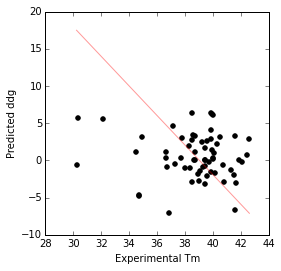

In [12]:
plt.figure( figsize=( 4, 4 ) )
plt.scatter( joined.tm, joined.total, color='k' )
plt.plot( ( joined.tm.min(), joined.tm.max() ), ( joined.total.max() , joined.total.min() ), color='red', alpha=0.4 ) #perfect correlation
plt.xlabel( 'Experimental Tm' )
plt.ylabel( 'Predicted ddg' )

So that's kind of underwhelming :) 

# Rosetta plus machine learning [outperforms `ddg_monomer`?]

Instead, let's make models of the mutants using `EnzRepackMinimize` and then try to use machine learning to get better correlation.

In [13]:
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import BaggingRegressor
from sklearn.grid_search import GridSearchCV
from glob import glob 

dfs = [ pandas.read_csv( i, sep=r'\s+' ) for i in glob( 'enzdes/out/*sc' ) ]
df = pandas.concat( dfs )

df.description = df.description.str[:-5]
#df = df.groupby( 'description' ).apply( low_10 )
df.set_index( 'description', inplace=True )
joined = df.join( fits )
joined

# fig, ax = plt.subplots( ncols=3, nrows=1, figsize=(10,3) )

# params = { 'l1_ratio': [ 0.001, 0.01, 0.1, 0.5, 0.9 ], }

# net = ElasticNetCV()
# bag = BaggingRegressor( net, n_estimators=1 )
# grid = GridSearchCV( bag, params )

# plt.scatter( preds, y, alpha=0.3, marker='.' )
# plt.set_xlabel( 'Predicted'.format( constant ) )
# plt.set_ylabel( 'Actual' )

,total_score,fa_rep,hbond_sc,all_cst,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,tot_NLconts_pm,tot_nlsurfaceE_pm,...,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm,tm,k,native,designed,position
bglb_101ARG_0,-181.17,627.77,-74.64,0.00,0.70,0.69,141,440,149,0.77,...,0.00,-11.67,0.90,8,1,NaN,NaN,NaN,NaN,NaN
bglb_101ARG_1,-178.47,628.40,-73.13,0.01,0.70,0.69,140,439,147,0.77,...,0.00,-11.69,0.90,8,1,NaN,NaN,NaN,NaN,NaN
bglb_101ARG_10,-172.64,630.54,-73.62,0.00,0.72,0.69,146,438,150,0.60,...,0.00,-11.33,0.90,8,1,NaN,NaN,NaN,NaN,NaN
bglb_101ARG_11,-172.31,630.38,-72.32,0.01,0.70,0.69,147,437,150,0.67,...,0.00,-10.54,0.90,7,1,NaN,NaN,NaN,NaN,NaN
bglb_101ARG_12,-174.02,630.88,-71.96,0.00,0.71,0.70,145,437,151,0.82,...,0.00,-10.88,0.90,7,1,NaN,NaN,NaN,NaN,NaN
bglb_101ARG_13,-173.88,630.71,-72.37,0.00,0.72,0.70,144,438,152,0.65,...,0.00,-11.43,0.90,8,1,NaN,NaN,NaN,NaN,NaN
bglb_101ARG_14,-162.52,632.57,-70.10,0.00,0.71,0.71,147,438,148,0.77,...,0.00,-10.36,0.90,7,1,NaN,NaN,NaN,NaN,NaN
bglb_101ARG_15,-174.29,630.06,-72.27,0.00,0.71,0.70,146,438,150,0.89,...,0.00,-11.63,0.90,8,1,NaN,NaN,NaN,NaN,NaN
bglb_101ARG_16,-171.72,631.39,-71.50,0.01,0.70,0.69,145,437,150,0.65,...,0.00,-10.80,0.90,7,1,NaN,NaN,NaN,NaN,NaN
bglb_101ARG_17,-172.89,630.89,-71.31,0.00,0.70,0.70,147,438,147,0.77,...,0.00,-10.55,0.90,7,1,NaN,NaN,NaN,NaN,NaN
